**Addestramento del modello di classificazione.**

*Variabile target: "Response".*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as ply
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

def chi2(X, y_target):
    """
    Calcolo del test di indipendenza tra variabile categoriche.
    X, y_target: rispettivamente variabile indipendente, variabile dipendente.
    """

    data = pd.crosstab(y_target, X)
    # data = pd.crosstab(dataset["Response"], dataset["Vintage"])

    chi2, p, dof, expected = chi2_contingency(data)

    print(f"Chi2 Stat: {chi2:.2f}")
    print(f"P-value: {p:.2f}")
    print(f"Degrees of freedom: {dof}")

    if p < 0.05:
        print("Le variabili sono dipendenti.")
    else:
        print("Le variabili sono indipendenti.")


def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], normalize=False,  title="Confusion Matrix"):
    """
    """

    cm = confusion_matrix(y_true, y_pred, normalize="true" if normalize else None)

    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted "+labels[0],"Predicted "+labels[1]])

    sns.heatmap(df_cm, annot=True, fmt=".2f" if normalize else "d")
    ply.title(title)

In [ ]:
dataset_original = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv", index_col=0)
dataset_original

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0


In [ ]:
dataset = dataset_original.copy()

Panoramica sui dati per capire il tipo di dato per features.

In [ ]:

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


In [ ]:
dataset.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Label encoding delle variabili categoriche tramite la funzione map().

In [ ]:
dataset["Gender"].value_counts()

Gender
Male      206089
Female    175020
Name: count, dtype: int64

In [ ]:
Gender_dict = {"Male": 0, "Female": 1}
dataset["Gender"] = dataset["Gender"].map(Gender_dict)
dataset["Gender"].value_counts()

Gender
0    206089
1    175020
Name: count, dtype: int64

In [ ]:
dataset["Vehicle_Age"].value_counts()

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

In [ ]:
Vehicle_Age_dict = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}
dataset["Vehicle_Age"] = dataset["Vehicle_Age"].map(Vehicle_Age_dict)
dataset["Vehicle_Age"].value_counts()

Vehicle_Age
1    200316
0    164786
2     16007
Name: count, dtype: int64

In [ ]:
dataset["Vehicle_Damage"].value_counts()

Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64

In [ ]:
Vehicle_Damage_dict = {"Yes": 0, "No": 1}
dataset["Vehicle_Damage"] = dataset["Vehicle_Damage"].map(Vehicle_Damage_dict)
dataset["Vehicle_Damage"].value_counts()

Vehicle_Damage
0    192413
1    188696
Name: count, dtype: int64

Eliminazione della variabile considerata poco informativa e difficile da gestire in quanto difficilmente raggruppabile.

In [ ]:
dataset = dataset.drop("Region_Code", axis=1)

In [ ]:
dataset["Policy_Sales_Channel"].value_counts()

Policy_Sales_Channel
152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
43.0          1
144.0         1
143.0         1
41.0          1
Name: count, Length: 155, dtype: int64

Raggruppamento della variabile "Policy_Sales_Channel" in 5 categorie distinte che rappresentano la quasi totalità delle osservazioni con una minima perdita informativa, successivamente verrano create 4 ulteriori colonne dalla medesima variabile attraverso OneHotEncoder.

In [ ]:
dataset["Policy_Sales_Channel"] = dataset["Policy_Sales_Channel"].apply(lambda x: x if str(x) in ["152.0", "26.0", "124.0", "160.0"] else 0.0)

**Features selection.**

*Metodi di analisi univariata.*

Analisi statistica per esplorare quali variabili categoriche sono indipendenti e quali no con il test per campioni indipendenti: Chi-quadro.

In [ ]:
X = dataset["Gender"]
y_target = dataset["Response"]
chi2(X, y_target)

Chi2 Stat: 1047.71
P-value: 0.00
Degrees of freedom: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["Driving_License"]
y_target = dataset["Response"]
chi2(X, y_target)

Chi2 Stat: 38.63
P-value: 0.00
Degrees of freedom: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["Previously_Insured"]
y_target = dataset["Response"]
chi2(X, y_target)

Chi2 Stat: 44357.96
P-value: 0.00
Degrees of freedom: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["Vehicle_Age"]
y_target = dataset["Response"]
chi2(X, y_target)

Chi2 Stat: 18771.89
P-value: 0.00
Degrees of freedom: 2
Le variabili sono dipendenti.


In [ ]:
X = dataset["Vehicle_Damage"]
y_target = dataset["Response"]
chi2(X, y_target)

Chi2 Stat: 47864.76
P-value: 0.00
Degrees of freedom: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["Policy_Sales_Channel"]
y_target = dataset["Response"]
chi2(X, y_target)

Chi2 Stat: 22441.59
P-value: 0.00
Degrees of freedom: 4
Le variabili sono dipendenti.


Analisi statistica per esplorare la distribuzione tra le variabili dicotomiche e a rapporti, tramite il boxplot.

La distribuzione della variabile "Annual_Premium" tra i valori che la la variabile categorica assume, non fornisce informazioni per la loro discriminazione, mentre l'elevata presenza di outlier comprometterebbe la stabilità del modello.

Valutare l'eliminazione.

<Axes: xlabel='Response', ylabel='Annual_Premium'>

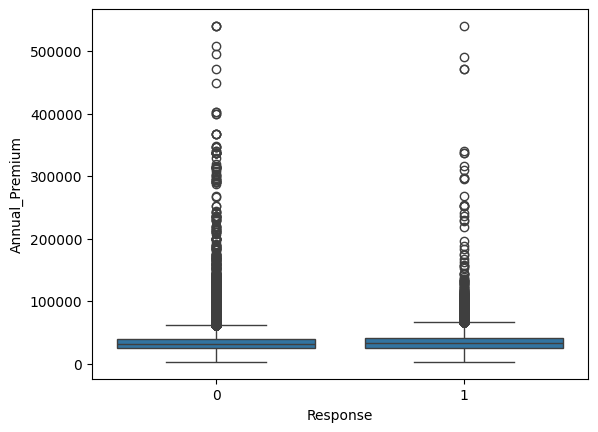

In [ ]:
sns.boxplot(x=dataset["Response"], y=dataset["Annual_Premium"], data=dataset)

La distribuzione della variabile "Age" tra i valori che la la variabile categorica assume, fornisce informazioni per la loro discriminazione.

Nonostante ciò, l'elevata presenza di outlier comprometterebbe la stabilità del modello.


Necessità di ulteriori analisi per poterne valutare l'eliminazione.

<Axes: xlabel='Response', ylabel='Age'>

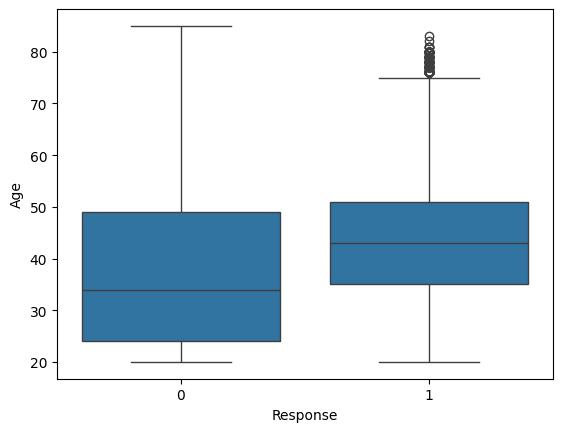

In [ ]:
sns.boxplot(x=dataset["Response"], y=dataset["Age"], data=dataset)

La distribuzione della variabile "VintAge" tra i valori che la la variabile categorica assume, non fornisce informazioni per la loro discriminazione.


Valutare l'eliminazione.

<Axes: xlabel='Response', ylabel='Vintage'>

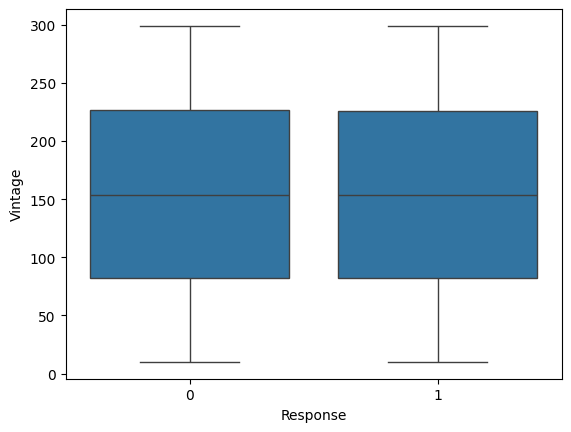

In [ ]:
sns.boxplot(x=dataset["Response"], y=dataset["Vintage"], data=dataset)

*Metodi di analisi multivariata.*

Correlazione di spearman che si presta meglio per l'analisi della correlazione con variabili categoriche.

<Axes: >

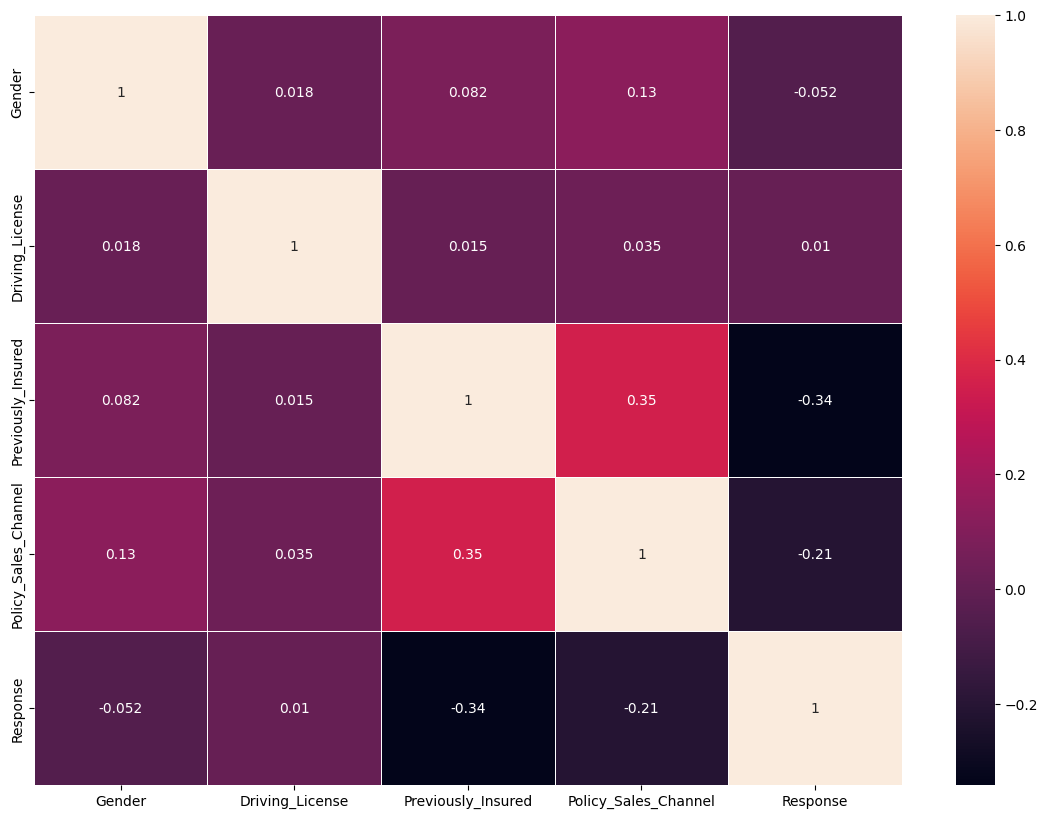

In [ ]:
ply.rcParams["figure.figsize"] = [14, 10]
corr_spearman = dataset.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, linewidths=.5)

Considerato il bassissimo livello di correlazione e la loro distribuzione osservata dai boxplot tra la variabile target e le variabili "Vintage" e "Annual_Premium" e "Age", si può procedere con la loro eliminazione. Se la variabile "Age" fosse stata maggiormente correlata al target si sarebbe potutto valutare l'eliminazione degli outlier.

In [ ]:
dataset = dataset.drop(["Vintage", "Annual_Premium", "Age"], axis=1)

<Axes: >

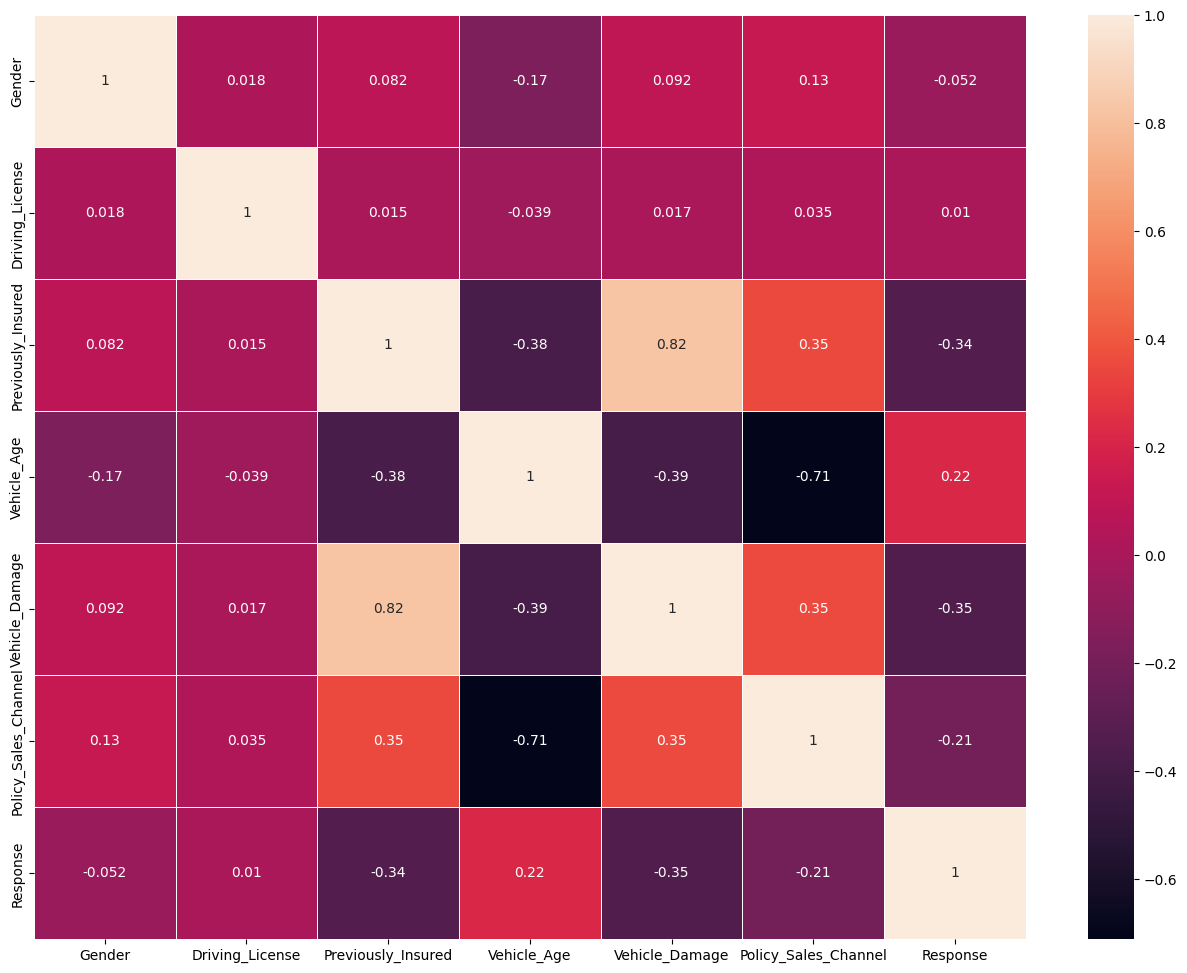

In [ ]:
corr_spearman = dataset.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, linewidths=.5)

Eliminazione delle features maggiormente correlate tra loro per evitare effetti di ridondanza che comprometterebbero la stabilità del modello.

In [ ]:
dataset[["Vehicle_Damage", "Previously_Insured"]].corr(method="spearman")

,Vehicle_Damage,Previously_Insured
Vehicle_Damage,1.000000,0.824143
Previously_Insured,0.824143,1.000000


In [ ]:
dataset[["Vehicle_Age", "Policy_Sales_Channel"]].corr(method="spearman")

,Vehicle_Age,Policy_Sales_Channel
Vehicle_Age,1.000000,-0.711494
Policy_Sales_Channel,-0.711494,1.000000


In [ ]:
dataset = dataset.drop(["Vehicle_Age", "Vehicle_Damage"], axis=1)

<Axes: >

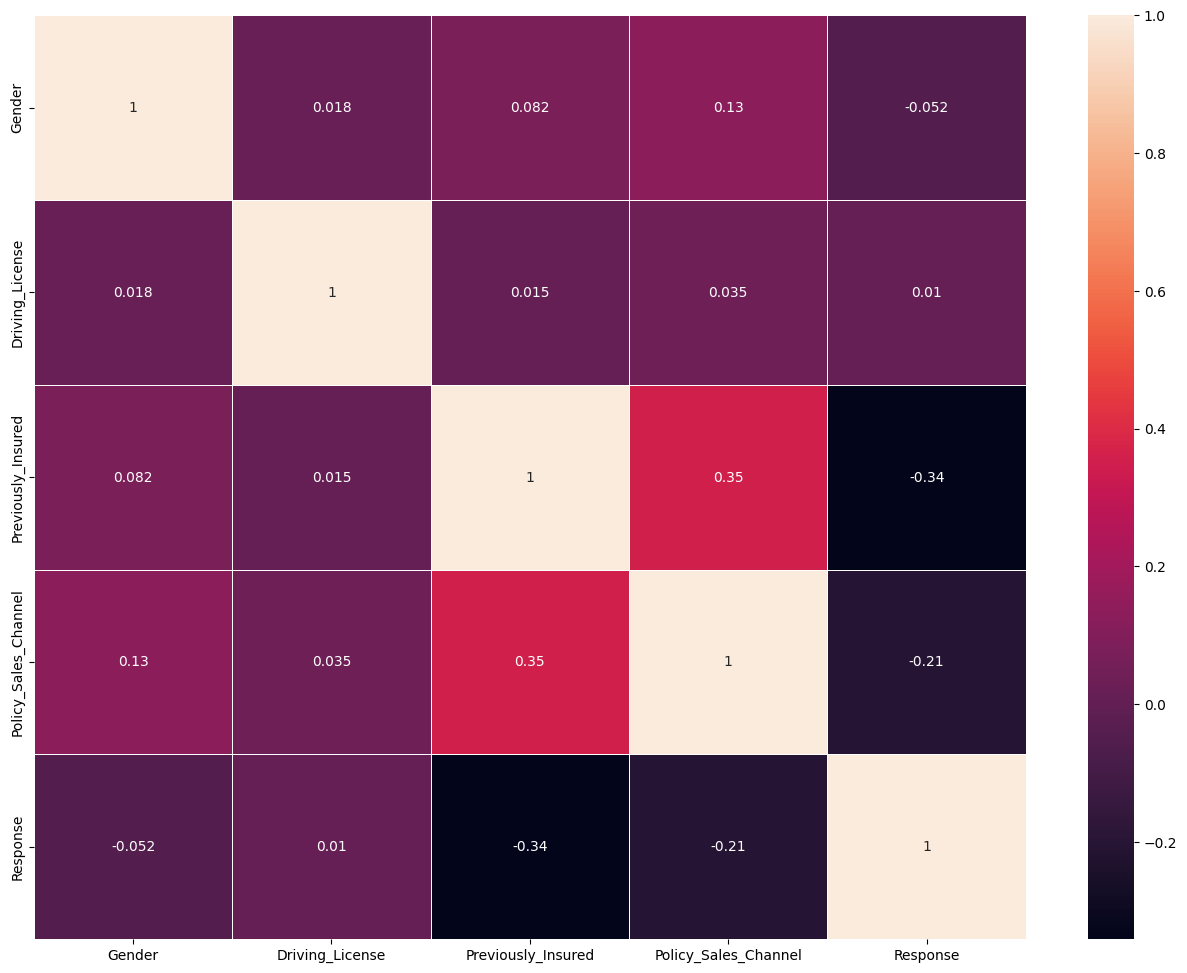

In [ ]:
corr_spearman = dataset.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, linewidths=.5)

**Addestramento del modello con quattro variabili, due delle quali presentano una bassa correlazione negativa con il target.**

La variabile target è pesantemente sbilanciata. Il primo modello terrà conto dello sbilanciamento solo tramite il parametro class_weight="balanced" nell'addestramento, successivamente verrà riaddestrato con ulteriori metodi di bilanciamento.

In [ ]:
counts = dataset["Response"].value_counts()
print(f"No = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%) ")
print(f"Si = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%) ")

No = 334399 (87.74%) 
Si = 46710 (12.26%) 


Divisione del dataset in train e test, quest'ultimo sarà composto con il 30% del dataset totale.

In [ ]:
X = dataset.drop("Response", axis=1).values
y = dataset["Response"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (266776, 4)
X_test: (114333, 4)


Creazione delle nuove colonne per gestire la variabile categorica non ordinabile "Policy_Sales_Channel" precedentemente divisa in 5 categorie, tramite il OneHotEncoder per la conversione e del ColumnTransformer per la trasformazione.

In [ ]:
c_transf = ColumnTransformer([("ohe", OneHotEncoder(), [3])], remainder="passthrough")
X_train = c_transf.fit_transform(X_train)
X_test = c_transf.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Utilizzo del StandardScaler per la standardizzazione del dataset cosi da portare i valori di diverse features alla stessa scala rendendo più semplice al modello l'apprendimento dei pattern sottostanti.

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Addestramento del modello di regressione logistca con il parametro class_weight="balanced" per gestire lo sbilanciamento della features target.

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Utilizzo delle metriche per valutare la bontà del modello.

Considerando il caso specifico nel quale il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno di un modello predittivo in grado di stimare se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo, le metriche di maggior interesse sono quelle che permettono di minimizzare un errore dove il cliente accetterebbe l'acquisto dell'assicurazione(1), ma il modello stima che non è cosi (0).

Le metriche maggiormente informative in questo caso specifico sono ordinate per importanza come segue: richiamo, F1 e la precisione, in ultimo l'accuratezza perchè più sensibile allo sbilanciamento.

In [ ]:
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    234063
           1       0.26      0.90      0.41     32713

    accuracy                           0.68    266776
   macro avg       0.62      0.78      0.60    266776
weighted avg       0.89      0.68      0.74    266776

TEST REPORT
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    100336
           1       0.27      0.91      0.41     13997

    accuracy                           0.68    114333
   macro avg       0.62      0.78      0.60    114333
weighted avg       0.89      0.68      0.74    114333



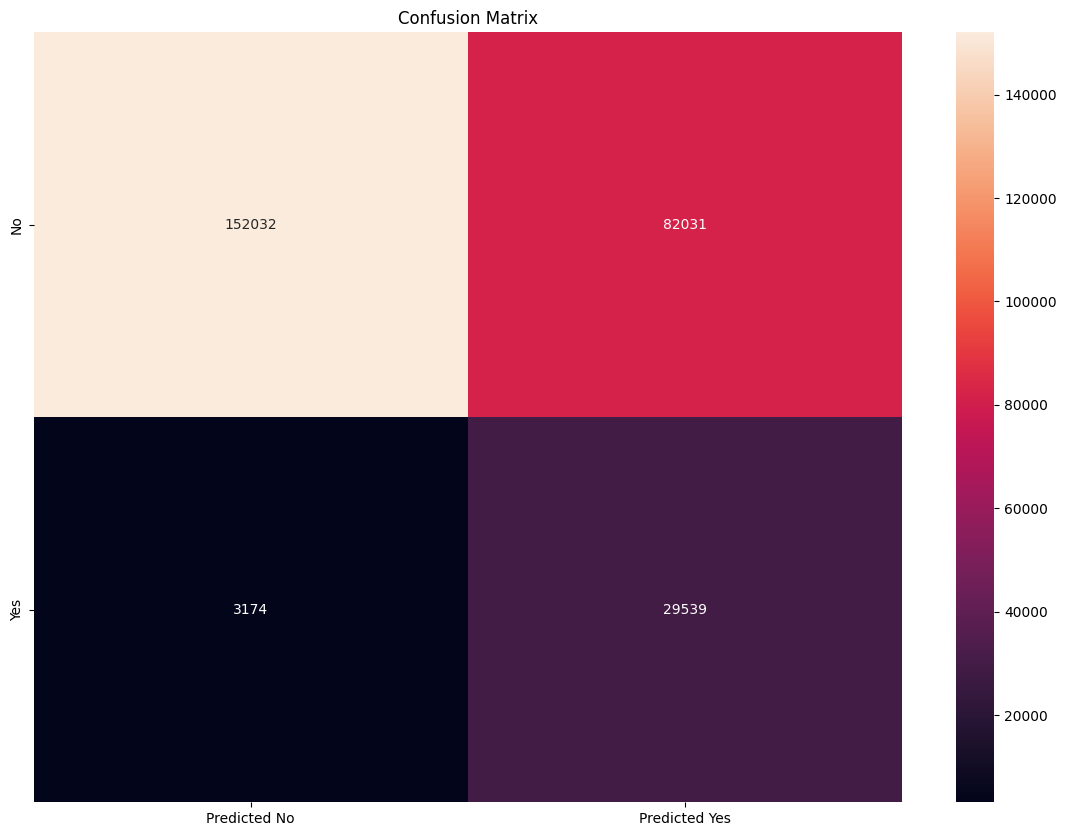

In [ ]:
plot_confusion_matrix(y_train, y_pred_train, ["No", "Yes"])

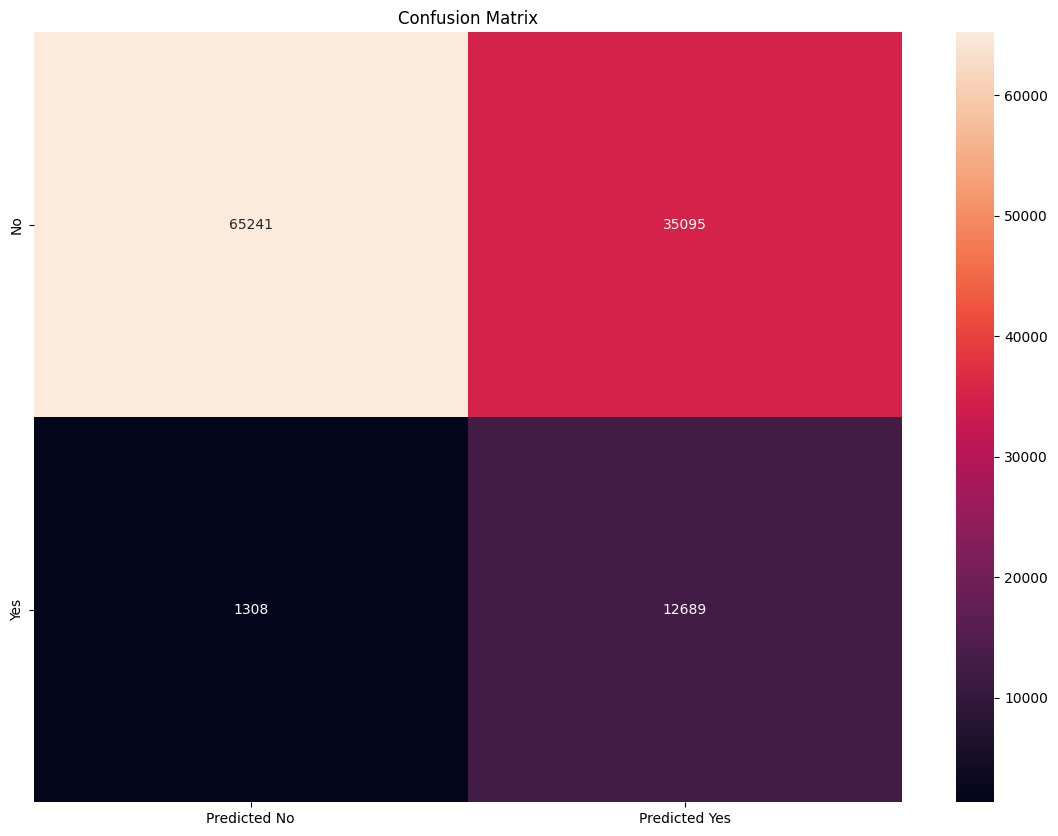

In [ ]:
plot_confusion_matrix(y_test, y_pred_test, ["No", "Yes"])

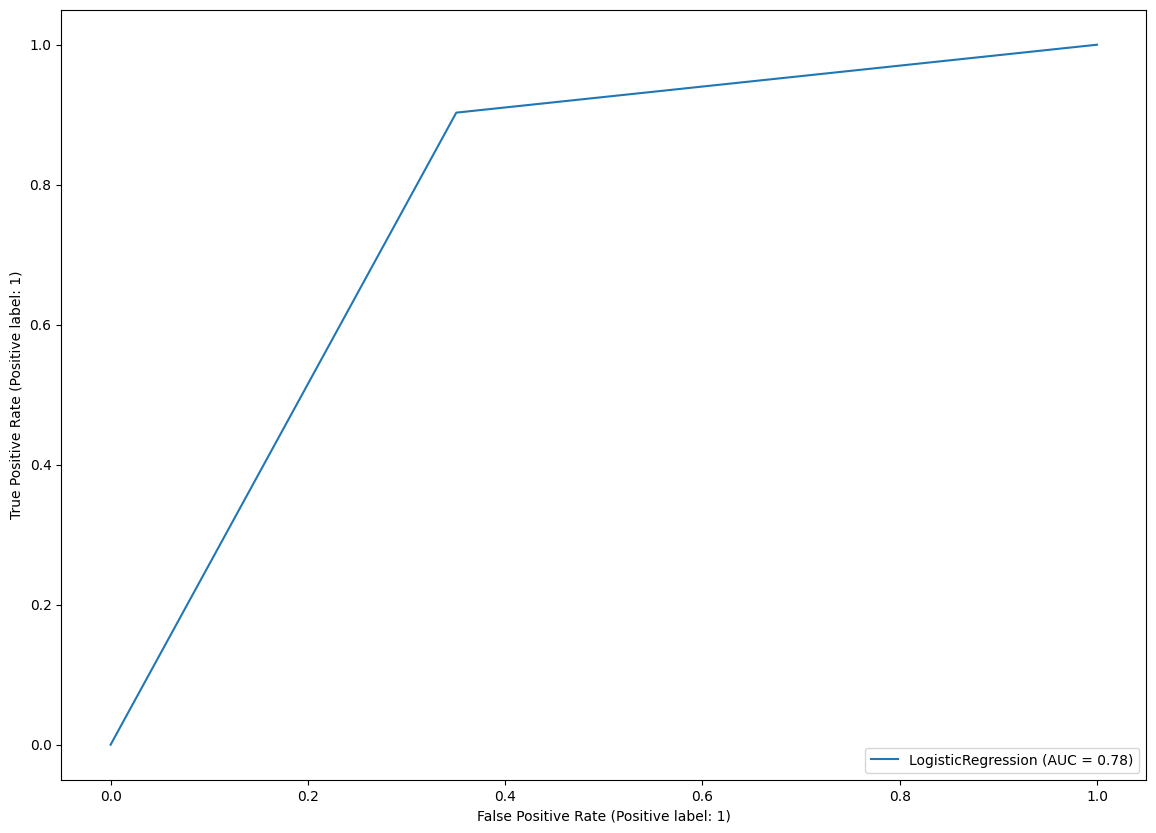

In [ ]:
RocCurveDisplay.from_predictions(y_train, y_pred_train, name="LogisticRegression")

Addestramento del modello con metodi di bilanciamento della variabile target: oversampling, per creare casualmente delle osservzioni appartenenti alla variabile sotto-rappresentata, in questo caso 1.

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (468126, 8)
X_test: (114333, 8)


Ricerca del parametro C_val per il peso della regolarizzazione sui dati sia con regolarizzazione L1 che L2, allo scopo di gestire il possibile overfitting causato dall'aumento delle osservazioni aggiunte per bilanciare la variabile target.

In [ ]:
for C_val in [0.1, 1, 10, 100]:
    lr = LogisticRegression(C=C_val, penalty="l1", solver="liblinear")
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_proba_train = lr.predict_proba(X_train)

    y_pred_test = lr.predict(X_test)
    y_proba_test =  lr.predict_proba(X_test)

    print(f"C={C_val}, Training richiamo: {recall_score(y_test, y_pred_test):3f}, Test richiamo: {recall_score(y_test, y_pred_test):3f}")
    print(f"C={C_val}, Training F1: {f1_score(y_test, y_pred_test):3f}, Test F1: {f1_score(y_test, y_pred_test):3f}")
    print("---------------------------------------------------------------")

C=0.1, Training richiamo: 0.906551, Test richiamo: 0.906551
C=0.1, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=1, Training richiamo: 0.906551, Test richiamo: 0.906551
C=1, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=10, Training richiamo: 0.906551, Test richiamo: 0.906551
C=10, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=100, Training richiamo: 0.906551, Test richiamo: 0.906551
C=100, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------


In [ ]:
for C_val in [0.1, 1, 10, 100]:
    lr = LogisticRegression(C=C_val, penalty='l2')
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_proba_train = lr.predict_proba(X_train)

    y_pred_test = lr.predict(X_test)
    y_proba_test =  lr.predict_proba(X_test)

    print(f"C={C_val}, Training richiamo: {recall_score(y_test, y_pred_test):3f}, Test richiamo: {recall_score(y_test, y_pred_test):3f}")
    print(f"C={C_val}, Training F1: {f1_score(y_test, y_pred_test):3f}, Test F1: {f1_score(y_test, y_pred_test):3f}")
    print("---------------------------------------------------------------")

C=0.01, Training richiamo: 0.906551, Test richiamo: 0.906551
C=0.01, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=0.1, Training richiamo: 0.906551, Test richiamo: 0.906551
C=0.1, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=1, Training richiamo: 0.906551, Test richiamo: 0.906551
C=1, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=10, Training richiamo: 0.906551, Test richiamo: 0.906551
C=10, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------
C=100, Training richiamo: 0.906551, Test richiamo: 0.906551
C=100, Training F1: 0.410774, Test F1: 0.410774
---------------------------------------------------------------


Le metriche mostrano la presenza di overfitting per la precisione e F1 senza nessun miglioramento per le restanti, il modello è in grado di generalizzare il pattern appreso nel training.

La matrice di confusione mostra un micro miglioramento dell'ordine delle decine di unità.

In [ ]:
lr = LogisticRegression(penalty='l2', C=1.0, class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.87      0.65      0.74    234063
           1       0.72      0.90      0.80    234063

    accuracy                           0.78    468126
   macro avg       0.79      0.78      0.77    468126
weighted avg       0.79      0.78      0.77    468126

TEST REPORT
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    100336
           1       0.27      0.91      0.41     13997

    accuracy                           0.68    114333
   macro avg       0.62      0.78      0.60    114333
weighted avg       0.89      0.68      0.74    114333



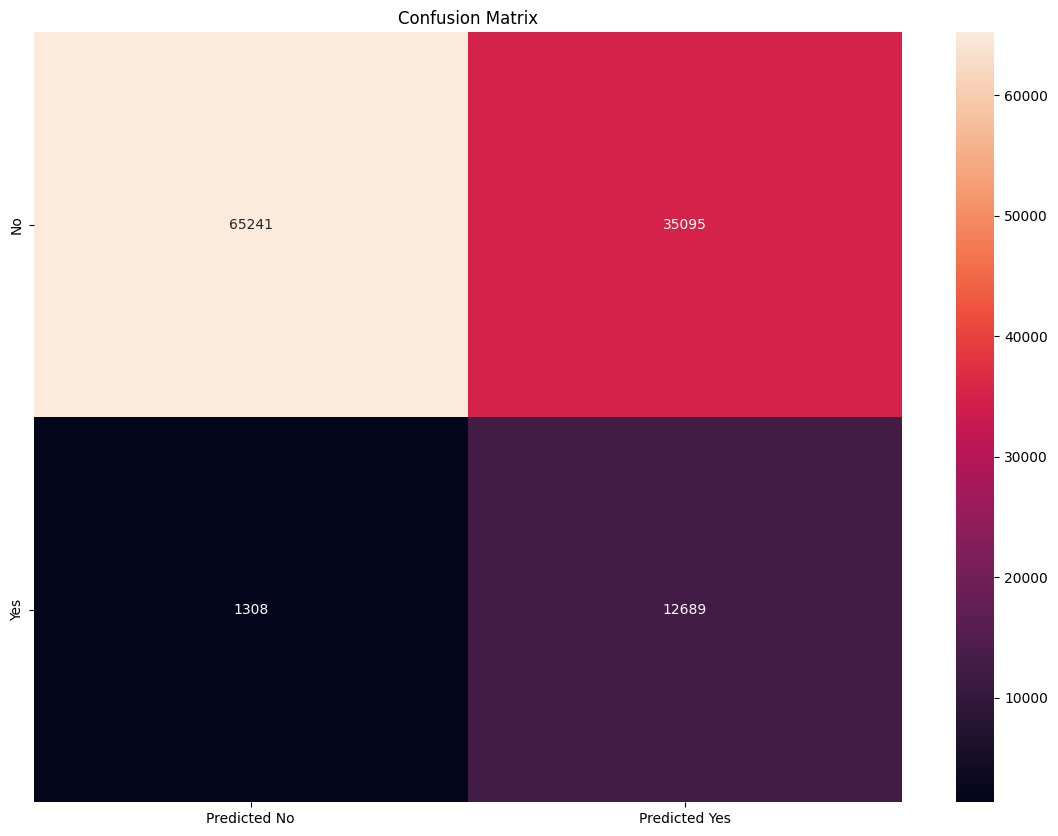

In [ ]:
plot_confusion_matrix(y_test, y_pred_test, ["No", "Yes"])

*Addestramento del modello mantenendo solo le features correlate al target.*

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Driving_License       381109 non-null  int64  
 2   Previously_Insured    381109 non-null  int64  
 3   Policy_Sales_Channel  381109 non-null  float64
 4   Response              381109 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 17.4 MB


<Axes: >

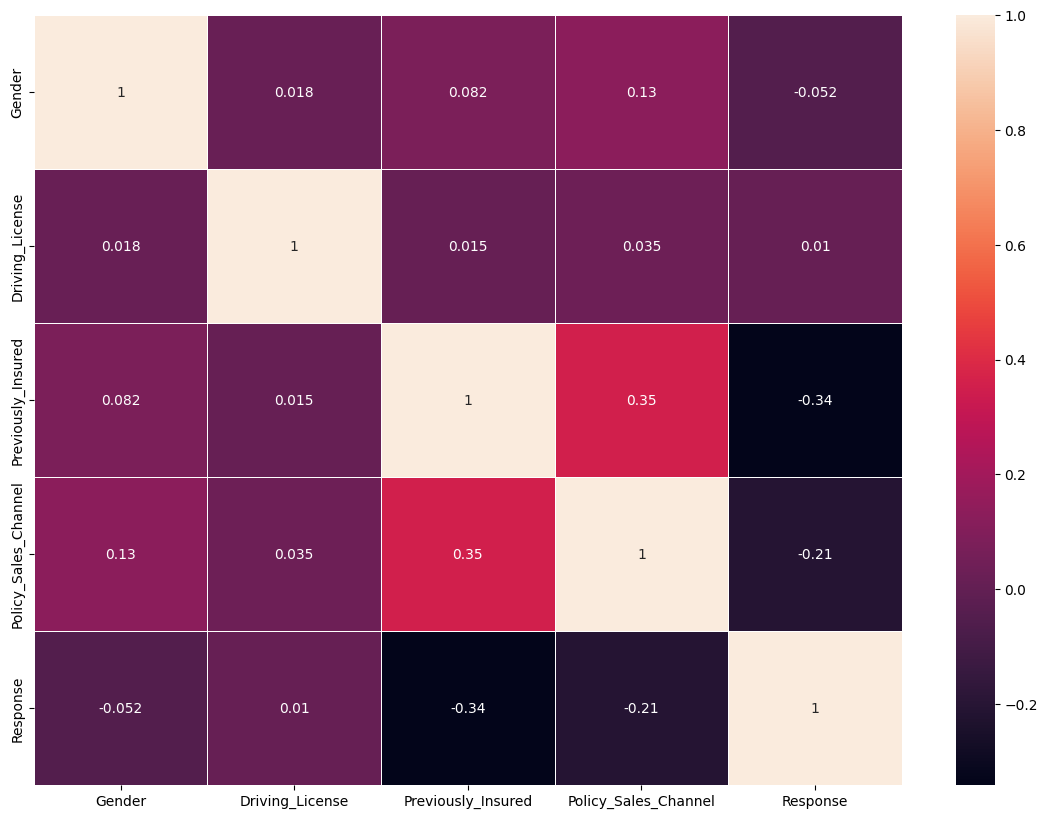

In [ ]:
corr_spearman = dataset.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, linewidths=.5)

In [ ]:
dataset = dataset.drop(["Driving_License", "Gender"], axis=1)

In [ ]:
X = dataset.drop("Response", axis=1).values
y = dataset["Response"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


c_transf = ColumnTransformer([("ohe", OneHotEncoder(), [1])], remainder="passthrough")
X_train = c_transf.fit_transform(X_train)
X_test = c_transf.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (266776, 6)
X_test: (114333, 6)


In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    234033
           1       0.26      0.91      0.41     32743

    accuracy                           0.68    266776
   macro avg       0.62      0.78      0.59    266776
weighted avg       0.89      0.68      0.73    266776

TEST REPORT
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    100366
           1       0.26      0.90      0.41     13967

    accuracy                           0.68    114333
   macro avg       0.62      0.78      0.59    114333
weighted avg       0.89      0.68      0.73    114333



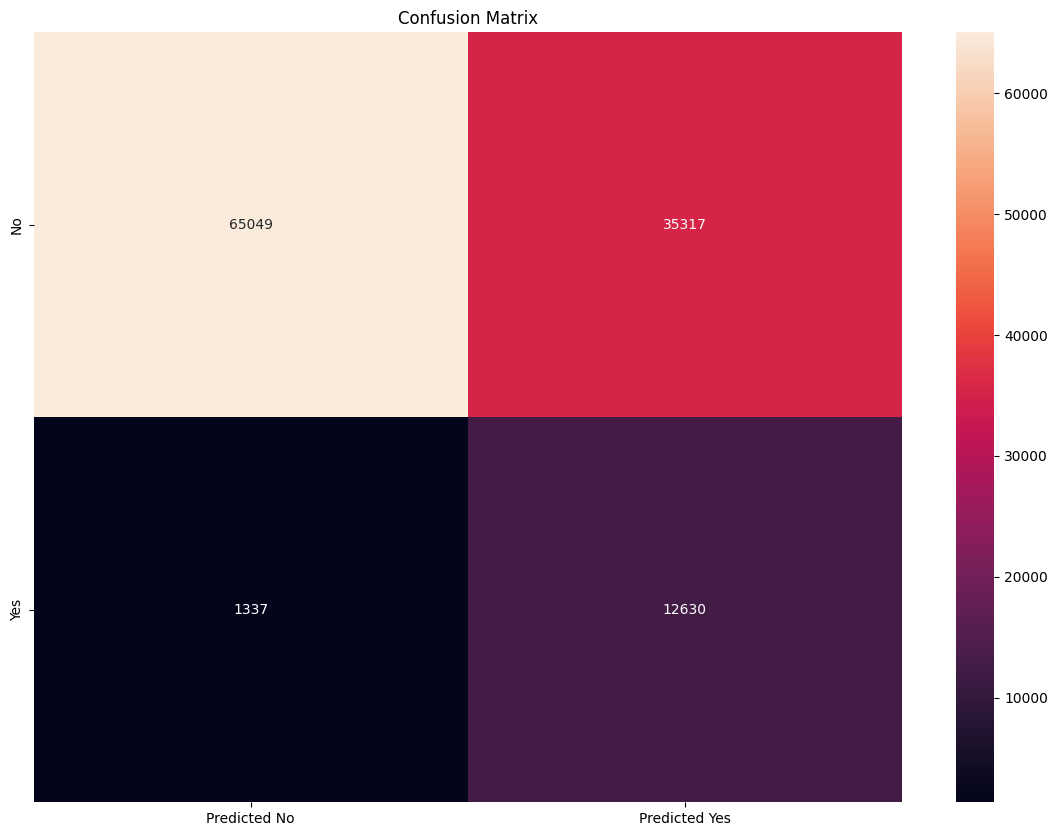

In [ ]:
plot_confusion_matrix(y_test, y_pred_test, ["No", "Yes"])

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (468066, 6)
X_test: (114333, 6)


Anche in questo caso il modello è in overfitting e non generalizza il pattern appreso nel training.

In [ ]:
lr = LogisticRegression(penalty='l2', C=1.0, class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.87      0.65      0.74    234033
           1       0.72      0.90      0.80    234033

    accuracy                           0.78    468066
   macro avg       0.80      0.78      0.77    468066
weighted avg       0.80      0.78      0.77    468066

TEST REPORT
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    100366
           1       0.26      0.90      0.41     13967

    accuracy                           0.68    114333
   macro avg       0.62      0.78      0.59    114333
weighted avg       0.89      0.68      0.73    114333



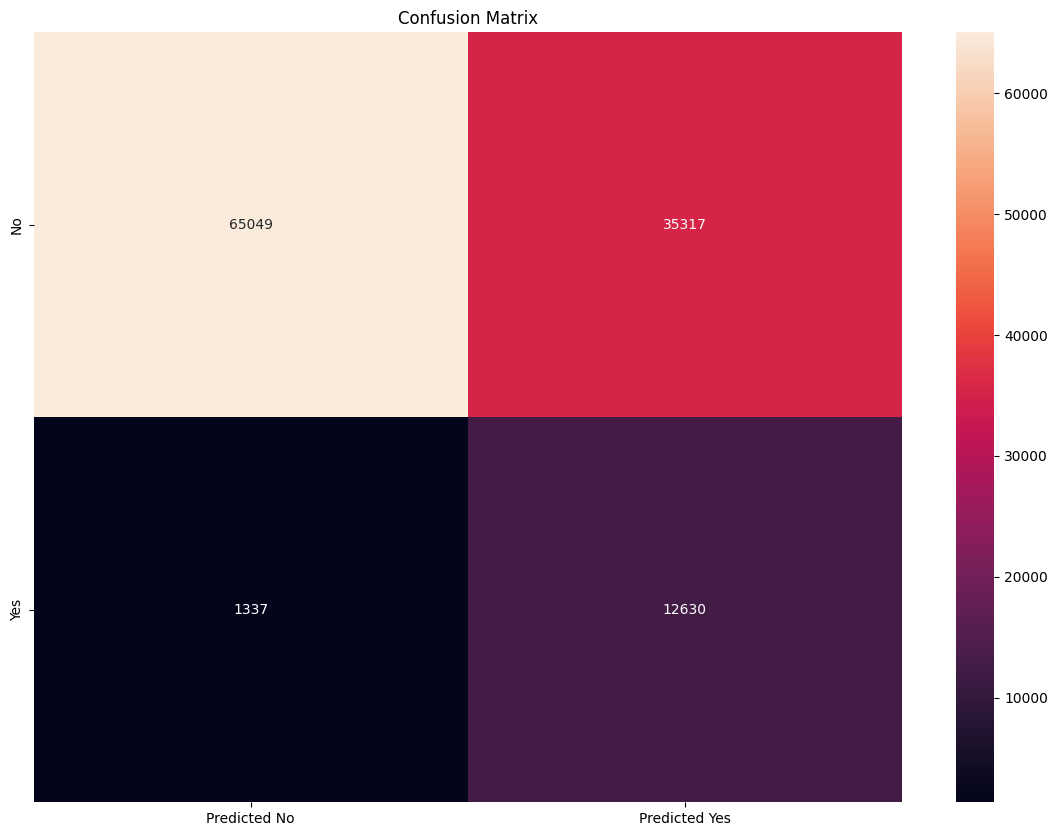

In [ ]:
plot_confusion_matrix(y_test, y_pred_test, ["No", "Yes"])

**Conclusioni**

Considerando il caso specifico il modello che ottiene le metriche migliori è il primo, dove lo sbilanciamento è gestito solamente dal parametro nel fit della regressione logisitca.

Le metriche come recall  e F1-score si mantengono buone.

TRAIN REPORT

              precision    recall  f1-score   support

           0       0.98      0.65      0.78    234063
           1       0.26      0.90      0.41     32713

    accuracy                           0.68    266776


TEST REPORT

              precision    recall  f1-score   support

           0       0.98      0.65      0.78    100336
           1       0.27      0.91      0.41     13997

    accuracy                           0.68    114333